In [1]:
import re
import sys
from typing import List,Dict

import numpy as np
import pandas as pd
import scanpy as sc

import torch as t


In [2]:
def read_file(file_name : str,
             )-> pd.DataFrame :
    """Read file
    Control if file extension is supported
    and read file.
    Parameter:
    ---------
    file_name : str
        path to file
    Returns:
    -------
        DataFrame with content of file
    """
    file = pd.read_csv(file_name,header = 0,index_col = 0,
                        compression = 'infer',sep = '\t')

    return file

In [3]:
#load SC data
sc_cnt  = read_file('./data/realdata/mousebrain/20191008080455248897.cnt_data.tsv')
print(sc_cnt)

                          Gpr17  Pak4  Neu4  Bfsp2  Tmem108  Enpp6  H2-Aa  \
cell                                                                        
10X04_1_AAACATACCTTATC-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X04_1_AAACATTGATTCTC-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X04_1_AAACCGTGGGAGGT-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X04_1_AAACGCTGGCAAGG-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X04_1_AAACGGCTGTGAGG-1    0.0   0.0   1.0    1.0      6.0    3.0    0.0   
...                         ...   ...   ...    ...      ...    ...    ...   
10X46_1_TTTCAGTGACAGCT-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X46_1_TTTCAGTGCCCTCA-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X46_1_TTTCCAGATAGAGA-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X46_1_TTTCCAGATGCATG-1    0.0   0.0   0.0    0.0      0.0    0.0    0.0   
10X46_1_TTTGACTGATTCGG-1    0.0   0.0   0.0    0.0      1.0    0.0    0.0   

In [4]:
#Load SC data tags
sc_lbl = read_file('./data/realdata/mousebrain/20191008080455248897.mta_data.tsv')
sc_lbl.columns = ["celltype"]
for i in range(sc_lbl.shape[0]):
    sc_lbl.iloc[i,0]=sc_lbl.iloc[i,0].split("_")[0]
print(sc_lbl)

                            celltype
cell                                
10X04_1_AAACATACCTTATC-1      Oligos
10X04_1_AAACATTGATTCTC-1     Neurons
10X04_1_AAACCGTGGGAGGT-1    Vascular
10X04_1_AAACGCTGGCAAGG-1  Astrocytes
10X04_1_AAACGGCTGTGAGG-1      Oligos
...                              ...
10X46_1_TTTCAGTGACAGCT-1     Neurons
10X46_1_TTTCAGTGCCCTCA-1  Astrocytes
10X46_1_TTTCCAGATAGAGA-1  Astrocytes
10X46_1_TTTCCAGATGCATG-1  Astrocytes
10X46_1_TTTGACTGATTCGG-1     Neurons

[8449 rows x 1 columns]


In [5]:
inter = sc_cnt.index.intersection(sc_lbl.index)
sc_cnt = sc_cnt.loc[inter,:]
lbl = sc_lbl.loc[inter]

In [6]:
adata_sc = sc.AnnData(X=sc_cnt)
adata_sc.obs['celltype']=lbl

/tmp/ipykernel_15616/3676992554.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_sc = sc.AnnData(X=sc_cnt)


In [7]:
#adata_sc.write('./data/realdata/mousebrain/scRNA.h5ad')

In [19]:
#load ST data
pths =['./data/realdata/mousebrain/st-hippo1.tsv','./data/realdata/mousebrain/st-hippo2.tsv']
mlist = []
start_pos0 = [0]
index = pd.Index([])
genes = pd.Index([])
for k,pth in enumerate(pths):
    # read file
    cnt = read_file(pth)
    mlist.append(cnt)
    # add file identifier k&- to rownames
    index = index.append(pd.Index([str(k) + '&-' + str(x) for \
                                       x in cnt.index ] ))

    # get union of all observed genes
    genes = genes.union(cnt.columns)
    # add length of matrix
    start_pos0.append(cnt.shape[0])

# only keep unique genes
genes = pd.Index(np.unique(genes))
print(mlist[0])
print(mlist[1])
print(genes)
print(start_pos0)

             Gnai3  Cdc45  Scml2  Apoh  Narf  Cav2  Klf6  Scmh1  Cox5a  Tbx2  \
4.83x31.08     0.0    0.0    0.0   0.0   0.0   0.0   0.0    1.0    4.0   0.0   
19.98x24.93    0.0    0.0    0.0   0.0   2.0   1.0   0.0    0.0    8.0   0.0   
15.87x9.01     1.0    0.0    0.0   0.0   1.0   0.0   1.0    0.0   13.0   0.0   
5.83x27.97     1.0    0.0    0.0   0.0   0.0   1.0   0.0    1.0    9.0   0.0   
16.84x19.97    0.0    0.0    0.0   0.0   0.0   0.0   0.0    2.0    9.0   0.0   
...            ...    ...    ...   ...   ...   ...   ...    ...    ...   ...   
25.0x6.08      0.0    0.0    0.0   0.0   0.0   0.0   0.0    0.0    1.0   0.0   
12.97x26.98    0.0    0.0    0.0   0.0   1.0   0.0   0.0    0.0   18.0   0.0   
2.98x29.04     0.0    0.0    0.0   0.0   0.0   1.0   0.0    2.0    8.0   0.0   
26.96x7.97     1.0    1.0    0.0   0.0   0.0   0.0   0.0    0.0   11.0   0.0   
3.87x30.13     0.0    0.0    0.0   0.0   0.0   2.0   0.0    0.0    5.0   0.0   

             ...  RP23-459B8.2  RP23-38

In [20]:
# get start position for entries of each file
start_pos = np.cumsum(np.array(start_pos0))
print(start_pos)
# prepare joint matrix, rownames are numbers
jmat = pd.DataFrame(np.zeros((start_pos[-1],
                                genes.shape[0])),
                    columns = genes,)
    # construct joint matrix
for k in range(len(start_pos) - 1):
    # set start and end pos based on
    # numeric rownames
    start = start_pos[k]
    end = start_pos[k+1] - 1
    jmat.loc[start:end,mlist[k].columns] = mlist[k].values
# set new indices
jmat.index = index
print(jmat)

[   0  604 1213]
                0610007P14Rik  0610009B22Rik  0610009L18Rik  0610009O20Rik  \
0&-4.83x31.08             1.0            1.0            0.0            0.0   
0&-19.98x24.93            0.0            0.0            0.0            0.0   
0&-15.87x9.01             0.0            1.0            0.0            1.0   
0&-5.83x27.97             2.0            2.0            1.0            0.0   
0&-16.84x19.97            0.0            0.0            0.0            0.0   
...                       ...            ...            ...            ...   
1&-12.06x26.02            3.0            0.0            0.0            1.0   
1&-25.01x6.17             0.0            0.0            0.0            0.0   
1&-12.97x27.02            0.0            0.0            0.0            0.0   
1&-25.99x5.15             2.0            1.0            0.0            0.0   
1&-26.95x8.06             0.0            1.0            0.0            0.0   

                0610010F05Rik  0610010K14Rik  

In [21]:
adata_st = sc.AnnData(X=jmat)
print(adata_st)

AnnData object with n_obs × n_vars = 1213 × 19199


/tmp/ipykernel_20203/4089395242.py:1: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata_st = sc.AnnData(X=jmat)


In [22]:
#adata_st.write('./data/realdata/mousebrain/Spatial.h5ad')

visualization

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def PieMarker(loc_list, frac_list, size, color_list):
    '''
    Return marker list for a point
    '''
    frac_cumsum = np.cumsum(frac_list)
    frac_cumsum = frac_cumsum/frac_cumsum[-1]
    marker_list = []
    previous = 0
    # calculate the points of the pie pieces
    for color, frac in zip(color_list, frac_cumsum):
        curr = frac
        x  = np.cos(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        y  = np.sin(2 * np.pi * np.linspace(previous, curr, 50)).tolist()
        xy = np.row_stack([[0, 0], np.column_stack([x, y])])
        marker_list.append({'marker': xy, 's': size*np.abs(xy).max()**2, 'facecolor': color, 'edgecolor': "darkgrey", 'linewidth': 0.1})
        previous = frac
    # scatter each of the pie pieces to create pies
    point_marker_list = []
    for marker in marker_list:
        point_marker_list.append(loc_list + [marker])
    return(point_marker_list)

def get_crd(w,as_he = False):
    crd = [x.replace('X','').split('x') for x in w.index.values]
    crd = np.array(crd).astype(float)
    if as_he:
        crd = crd[:,[1,0]]
        crd[:,1] = crd[:,1].max() - crd[:,1] + crd[:,1].min()
    return crd

def split_joint_matrix(jmat):
    try:
        idx, name = zip(*[ idx.split('&-') for \
                          idx in jmat.index ])
    except:
        print("_".join([f"Matrix provided is not",
                        f"a joint matrix generated",
                        f"by make_joint_matrix",
                       ]
                      )
             )

    # convert names to pandas index
    name = pd.Index(name)
    # get identifers
    idx = np.array(idx).astype(int)
    # get unique identifiers
    uidx = np.unique(idx)
    # list to store matrices
    matlist = []
    # get all individual matrices
    for k in uidx:
        # get indices with same identifiers
        sel = (idx == k)
        # select indices with same identifiers
        tm = jmat.iloc[sel,:]
        # set index to original indices
        tm.index = pd.Index([x.replace('&-','_') for \
                             x in name[sel].values])
        # append single matrix to list
        matlist.append(tm)

    return matlist

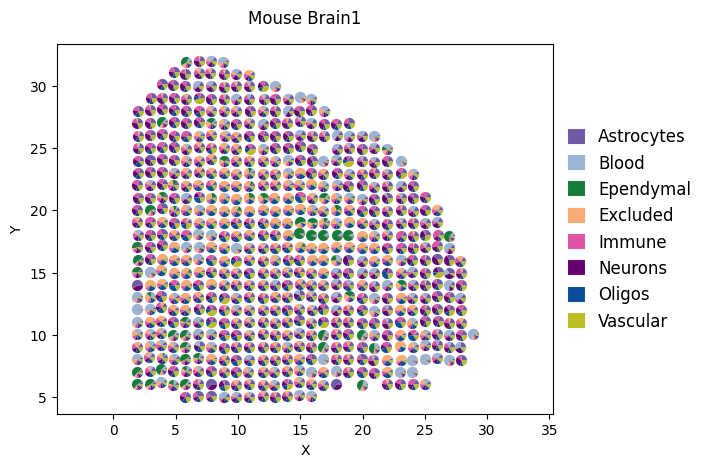

In [41]:
st_deconv=sc.read_h5ad("./data/realdata/mousebrain/pygGCN_result1.h5ad")
st_deconv_df = pd.DataFrame(st_deconv.X,index=st_deconv.obs_names,columns=st_deconv.var_names)
st_deconv_df = st_deconv_df.loc[:,np.unique(st_deconv_df.columns)]
st_deconv_df = (st_deconv_df.T/st_deconv_df.sum(axis=1)).T
st_deconv_df = st_deconv_df.fillna(0)

wlist = split_joint_matrix(st_deconv_df)
st_loc_list = [get_crd(w) for w in wlist]
st_deconv_df=wlist[0]
st_loc=st_loc_list[0]
st_loc_df=pd.DataFrame(st_loc,index=st_deconv_df.index,columns=["X","Y"])

DefaulfColorPalette = [
    "#6F5AA8", "#9BB4D6", "#137D39", "#FDAB75", "#E154A5", "#650171", "#084E99", "#BCBD22",
    "#B279A2", "#EECA3B", "#17BECF", "#FF9DA6", "#778AAE", "#1B9E77",
    "#A6761D", "#526A83", "#B82E2E", "#80B1D3", "#68855C", "#D95F02",
    "#BEBADA", "#AF6458", "#D9AF6B", "#9C9C5E", "#625377", "#8C785D",
    "#88CCEE", "#E73F74", "#FFFFB3", "#CCEBC5", "#332288", "#A65628"
]
color_pal = DefaulfColorPalette

pt_size=8
out_prefix="Mouse Brain2"
fig = plt.figure()
ax = fig.add_subplot()
for i in st_deconv_df.index:
    deconv_list = st_deconv_df.loc[i,:]
    loc_list = st_loc_df.loc[i,:].tolist()
    point_marker_list = PieMarker(loc_list[0:2], deconv_list, pt_size**2, color_pal)
    for point_marker in point_marker_list:
        ax.scatter(point_marker[0], point_marker[1], **point_marker[-1])
# add legends
celltypes = st_deconv_df.columns
patch_list = []
for i in range(len(celltypes)):
    patch_list.append(mpatches.Patch(facecolor = color_pal[i], label = celltypes[i], edgecolor = "darkgrey", linewidth=0.1))
ax.legend(handles = patch_list, loc='center left', bbox_to_anchor=(1, 0.5), fontsize = '12', frameon = False,
    handlelength=1, handleheight=1)
ax.axis('equal')
ax.set_xlabel(st_loc_df.columns[0])
ax.set_ylabel(st_loc_df.columns[1])
ax.set_title(out_prefix, pad = 15)
# save figure
# plot_file = os.path.join("./data/realdata/mousebrain/mousebrain2/", "Mouse_Brain2_scatterpie_plot.pdf")
# fig.savefig(plot_file, bbox_inches = "tight")
plt.show(fig)

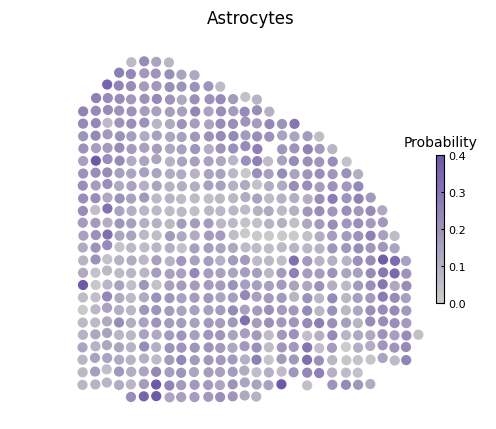

In [60]:
crd=np.array(st_loc_df.iloc[:,0:2]).astype(float)

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

c_dict = {'red':  ((0.0, 0.8, 0.8),
                   (1.0, 0.43, 0.43)),

          'green': ((0.0, 0.8, 0.8),
                    (1.0, 0.35, 0.35)),

          'blue':  ((0.0, 0.8, 0.8),
                    (1.0, 0.66, 0.66))
         }

mycolor_cmp = mcolors.LinearSegmentedColormap('mycolor', c_dict)

fig = plt.figure()
ax = fig.add_subplot()
celltypes = sorted(st_deconv_df.columns)
id=0
vmin = 0
vmax = 0.4
points = plt.scatter(x = crd[:,0], y = crd[:,1], 
                c=st_deconv_df.iloc[:, id],cmap = mycolor_cmp,
                alpha=1, s = 40,vmin = vmin,vmax = vmax)

fc=fig.colorbar(points,shrink=0.4, pad=-0.1)
ax2=fc.ax
ax2.set_title('Probability',fontsize=10)
ax2.tick_params(which='major',direction='in',labelsize=8,length=2.5)
ax2.tick_params(which='minor',direction='in')

#plt.colorbar(shrink=0.4, pad=-0.2,label="Probability")
ax.axis('equal')
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
for v in ax.axes.spines.values():
        v.set_edgecolor('none')
ax.set_title(celltypes[id], pad = 15)
plot_file = os.path.join("./data/realdata/mousebrain/mousebrain2/", "%s_scatter_plot.pdf" %(celltypes[id]))
fig.savefig(plot_file, bbox_inches = "tight")
plt.show(fig)